In [254]:
import numpy as np
import matplotlib.pyplot as plt
from pysph.base.utils import get_particle_array
from pysph.tools.interpolator import (
    Interpolator, get_bounding_box
)
from pysph.base import nnps

In [147]:
def make_test_data(dx=0.2, L=1, hdx=1.0, dim=2):
    _x = np.arange(dx / 2, L, dx)
    if dim == 1:
        x = _x.copy()
        y = np.zeros_like(x)
        z = np.zeros_like(x)
    elif dim == 2:
        x, y = np.meshgrid(_x, _x)
        z = np.zeros_like(x)
    elif dim == 3:
        x, y, z = np.meshgrid(_x, _x, _x)
        
    x, y, z = [t.ravel() for t in (x, y, z)]

    h = np.ones_like(x)*dx*hdx
    rho = np.ones_like(x)
    m = rho*dx**(dim)

    fluid = get_particle_array(
        name="fluid", x=x, y=y, z=z, h=h, m=m, rho=rho, exact=0
    )
    return fluid

In [258]:
def plot_pa(particle_arrays, dim, BB=None):
    if dim == 3:
        raise NotImplementedError("3D plotting not implemented yet.")
    tight_bounds = None
    for i, pa in enumerate(particle_arrays):
        label = pa.name
        if 'fluid' in pa.name:
            c = 'blue'
            tight_bounds = get_bounding_box([pa], tight=True)
            dy = 0.0
        elif '1' in pa.name:
            c = 'red'
            dy = 0.1
        elif '2' in pa.name:
            c = 'green'
            tight_bounds = get_bounding_box([pa], tight=True)
            dy = -0.1
        else:
            c = 'black'
            dy = 0.0
        
        if dim != 1:
            dy *= 0
        plt.scatter(pa.x, pa.y+dy, c=c, s=10, label=label)

    if tight_bounds is not None and dim == 2:
        xmin, xmax, ymin, ymax, zmin, zmax = tight_bounds
        plt.vlines([xmin, xmax], ymin, ymax, color='k', linestyle='--')
        plt.hlines([ymin, ymax], xmin, xmax, color='k', linestyle='--')
    if BB is not None:
        # print(BB)
        xmin, xmax, ymin, ymax, zmin, zmax = BB
        plt.xlim(xmin, xmax)
        _tmp = np.arange(np.round(xmin, 1), np.round(xmax, 1), 0.2)
        plt.xticks(_tmp)
        if dim == 2:
            plt.ylim(ymin, ymax)
            _tmp = np.arange(np.round(ymin, 1), np.round(ymax, 1), 0.2)
            plt.yticks(_tmp)

    # plt.axis("equal")
    plt.legend()

def get_nx_ny_nz(bounds, delta):
    """Given the bounds of the domain and the desired spacing, this function
    returns the number of cells in each direction.
    """
    bounds = np.asarray(bounds, dtype=float)
    delta = np.asarray(delta, dtype=float)
    dimensions = np.ceil((bounds[1::2] - bounds[::2]) / delta).astype(int)
    # If zero cells are required in any direction, set it to 1.
    dimensions[dimensions == 0] = 1
    return dimensions

def create_points(bounds, shape):
    b = bounds
    n = shape
    x, y, z = np.mgrid[
        b[0]:b[1]:n[0]*1j,
        b[2]:b[3]:n[1]*1j,
        b[4]:b[5]:n[2]*1j,
    ]
    return x, y, z

def get_max_h_in_arrays(particle_arrays):
    hmax = -1.0
    for array in particle_arrays:
        hmax = max(array.h.max(), hmax)
    return hmax

In [259]:
def create_ghosts(
        particle_arrays, dim, dx, num_layers=2
):    
    if num_layers <= 0:
        raise ValueError("num_layers must be greater than 0")
    
    tight_bounds = get_bounding_box(particle_arrays, tight=True)
    xmin, xmax, ymin, ymax, zmin, zmax = tight_bounds
    ND = dx*num_layers
    # print(f"tight_bounds: {tight_bounds}")
    
    ## Create Ghost-1
    ghost1_bounds = np.array(
        [xmin - ND, xmax + ND, ymin - ND, ymax + ND, zmin - ND, zmax + ND]
    )
    if dim == 1:
        ghost1_bounds[2:] = 0
    elif dim == 2:
        ghost1_bounds[4:] = 0
    print(f"ghost1_bounds: {ghost1_bounds}")
    shape = get_nx_ny_nz(ghost1_bounds, dx)
    print(f'shape: {shape}')
    x, y, z = create_points(ghost1_bounds, shape)
    xr, yr, zr = x.ravel(), y.ravel(), z.ravel()
    
    # Mask all the points inside the tight_bounds
    mask = (xr < xmin) | (xr > xmax)
    if dim > 1:
        mask |= (yr < ymin) | (yr > ymax)
    if dim > 2:
        mask |= (zr < zmin) | (zr > zmax)
    xr, yr, zr = xr[mask], yr[mask], zr[mask]
    
    h = dx*np.ones_like(xr)
    ghost1_pa = get_particle_array(
        name="ghost1", x=xr, y=yr, z=zr, h=h,
    )

    # Create Ghost-2
    shape = get_nx_ny_nz(tight_bounds, dx)
    pa = particle_arrays[0]
    x, y, z = pa.x, pa.y, pa.z
    xr, yr, zr = x.ravel(), y.ravel(), z.ravel()

    # Mask all the points inside the tight_bounds
    mask = (xr > xmin+ND) & (xr < xmax-ND)
    if dim > 1:
        mask &= (yr > ymin+ND) & (yr < ymax-ND)
    if dim > 2:
        mask &= (zr > zmin+ND) & (zr < zmax-ND)
    xr, yr, zr = xr[~mask], yr[~mask], zr[~mask]

    h = dx*np.ones_like(xr)
    ghost2_pa = get_particle_array(
        name="ghost2", x=xr, y=yr, z=zr, h=h,
    )

    return ghost1_pa, ghost2_pa

ghost1_bounds: [-0.1  1.1 -0.1  1.1  0.   0. ]
shape: [30 30  1]


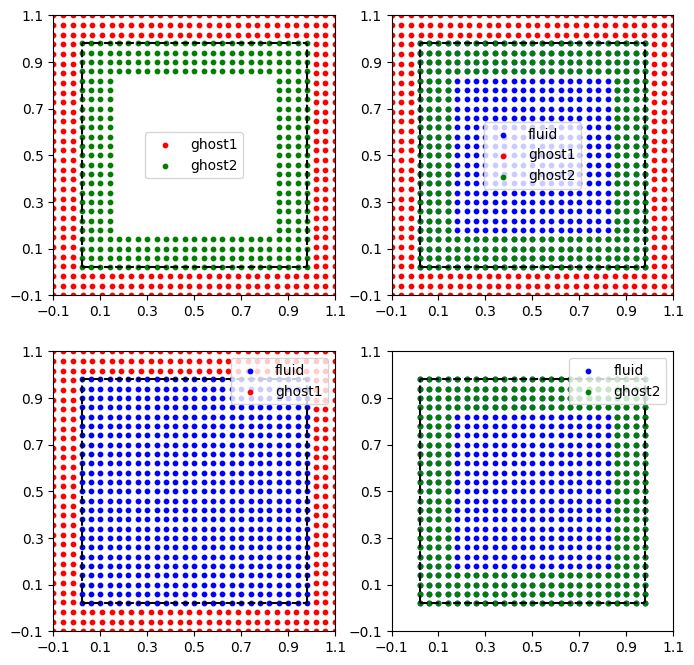

In [260]:
dim = 2
dx = 0.04
hdx = 1.2
num_layers = 3
pa = make_test_data(dx=dx, hdx=hdx, dim=dim)

gpa1, gpa2 = create_ghosts([pa], dim=dim, dx=dx, num_layers=num_layers)
BB = get_bounding_box([pa, gpa1, gpa2], tight=True)
_fs = (8, 8) if dim == 2 else (16, 4)
plt.figure(figsize=_fs)
plt.subplot(2, 2, 1)
plot_pa([gpa1, gpa2], dim=dim, BB=BB)
plt.subplot(2, 2, 2)
plot_pa([pa, gpa1, gpa2], dim=dim, BB=BB)
plt.subplot(2, 2, 3)
plot_pa([pa, gpa1], dim=dim, BB=BB)
plt.subplot(2, 2, 4)
plot_pa([pa, gpa2], dim=dim, BB=BB)

In [261]:
def mirror_points_along_line(
    xs, ys, A, B, C, plot=False, translate=(0,0)
):
    """
    Mirror the points (xs, ys) along the line Ax + By + C = 0.
    """
    # Mirror the points along the line Ax + By + C = 0.
    x, y = xs.ravel(), ys.ravel()
    M = np.sqrt(A**2 + B**2)
    Aprime, Bprime, Cprime = A/M, B/M, C/M

    D = Aprime*x + Bprime*y + Cprime
    xprime = x - 2*Aprime*D
    yprime = y - 2*Bprime*D

    # Plot original and mirrored points.
    if plot:
        # plt.figure()
        plt.scatter(x, y, c="b", s=10, label="original")
        label = "mirrored"
        plt.scatter(
            xprime, yprime, c="b", s=10, label=label, alpha=0.2
        )
        if translate != (0,0):
            label += " (translated)"
            dx, dy = translate
            plt.scatter(
                xprime+dx, yprime+dy, c="r", s=10, label=label, alpha=0.2
            )
        # Plot the line.
        if B != 0:
            xline = np.linspace(x.min(), x.max(), 100)
            yline = (-C - A*xline)/B
        else:
            yline = np.linspace(y.min(), y.max(), 100)
            xline = (-C - B*yline)/A
        if A == 0:
            label = f"{B}y = "
        elif B == 0:
            label = f"{A}x = "
        else:
            label = f"{A}x + {B}y = "
        label += f"{C}"
        
        plt.plot(xline, yline, c="k", label=fr"${label}$")
        plt.axis("equal")
        plt.legend()
    
    dx, dy = translate
    xprime += dx
    yprime += dy
    
    return xprime, yprime

In [262]:
tight_bounds = get_bounding_box([pa], tight=True)
xmin, xmax, ymin, ymax, zmin, zmax = tight_bounds
Lx, Ly, Lz = xmax - xmin, ymax - ymin, zmax - zmin
tight_bounds

array([0.02, 0.98, 0.02, 0.98, 0.  , 0.  ])

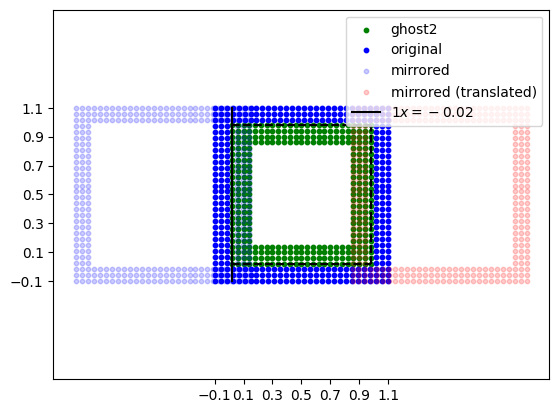

In [263]:
tmp = gpa1
x, y = tmp.x, tmp.y

plot_pa([gpa2], dim=dim, BB=BB)
x1, y1 = mirror_points_along_line(
    x, y, 1, 0, -xmin, plot=1, translate=(2*Lx,0)
)

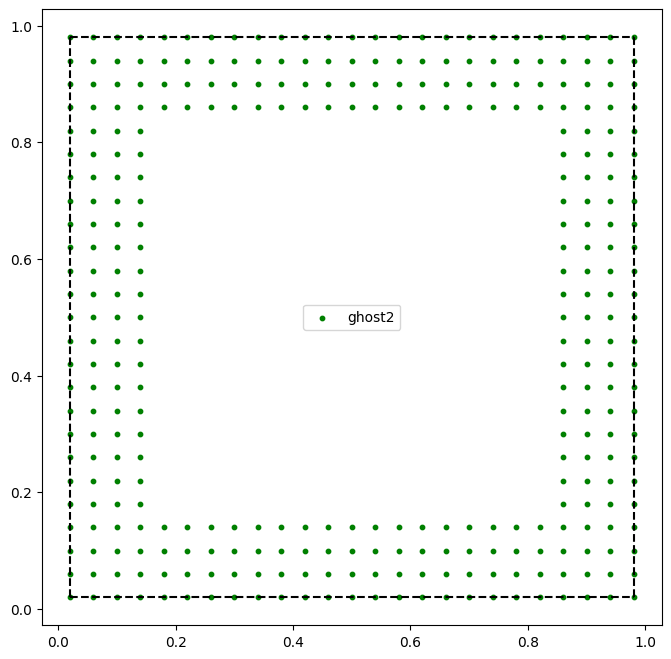

In [271]:
temp_pa = get_particle_array(
    name="temp", x=x1, y=y1, h=dx*np.ones_like(x1)
)
plt.figure(figsize=(8, 8))
plot_pa([gpa2], dim=dim)